In [3]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import bdpy

In [18]:
train_data = bdpy.BData('../../fMRI data/sub-01_perceptionNaturalImageTraining_original_VC.h5')
test_data = bdpy.BData('../../fMRI data/sub-01_perceptionNaturalImageTest_original_VC.h5')
train_data.show_metadata()

| Key         | Description          |
|-------------|----------------------|
| VoxelData   | 1 = VoxelData        |
| Run         | 1 = Run              |
| Block       | 1 = Block            |
| Label       | 1 = Label            |
| image_index | Label stimulus_index |
| stimulus_id | Label stimulus_id    |
| voxel_x     | Voxel x coordinate   |
| voxel_y     | Voxel y coordinate   |
| voxel_z     | Voxel z coordinate   |
| ROI_V1      | 1 = ROI V1           |
| ROI_V2      | 1 = ROI V2           |
| ROI_V3      | 1 = ROI V3           |
| ROI_V4      | 1 = ROI V4           |
| ROI_LOC     | 1 = ROI LOC          |
| ROI_FFA     | 1 = ROI FFA          |
| ROI_PPA     | 1 = ROI PPA          |
| ROI_LVC     | 1 = ROI LVC          |
| ROI_HVC     | 1 = ROI HVC          |
| ROI_VC      | 1 = ROI VC           |


In [34]:
vx = train_data.select("voxel_x")
vy = train_data.select("voxel_y")
vz = train_data.select("voxel_z")

print(vx.shape)
print(vy.shape)
print(vz.shape)

xmin, xmax = np.min(vx), np.max(vx)
zmin, zmax = np.min(vz), np.max(vz)

print(xmin, xmax)
print(zmin, zmax)

print((xmax-xmin) / (zmax-zmin))


(6000, 256)
(6000, 0)
(6000, 100)
-260.32991500974316 215.96770936393705
-216.4659788575275 150.82108266222724
1.2967993547141663


In [37]:
factors = [1, 2, 11, 13, 22, 26, 41, 82, 143, 286, 451, 533, 902, 1066, 5863, 11726]
factor_pairs = []
for i in range(len(factors)//2):
    factor_pairs.append((factors[i], factors[-(i+1)]))

reversed_pairs = [tuple(reversed(pair)) for pair in factor_pairs]

print(factor_pairs)

[(1, 11726), (2, 5863), (11, 1066), (13, 902), (22, 533), (26, 451), (41, 286), (82, 143)]


In [ ]:
train_vc = train_data.select("ROI_VC")
print(train_vc.shape)

train_sample = train_vc[0]

print(train_sample[:5])

# train_sample = np.reshape(train_sample, ( 82, 143))
train_sample = (train_sample - np.min(train_sample)) / (np.max(train_sample) - np.min(train_sample))

fig, ax = plt.subplots(nrows=8, ncols=1)
for r in range(8):
    train_sample = np.reshape(train_sample, factor_pairs[r])
    ax[r].imshow(train_sample, cmap="gray")
fig.set_size_inches(12, 7)

fig2, ax2 = plt.subplots(nrows=1, ncols=8)
for c in range(8):
    train_sample = np.reshape(train_sample, reversed_pairs[c])
    ax2[c].imshow(train_sample, cmap="gray")
fig2.set_size_inches(7, 12)

plt.show()

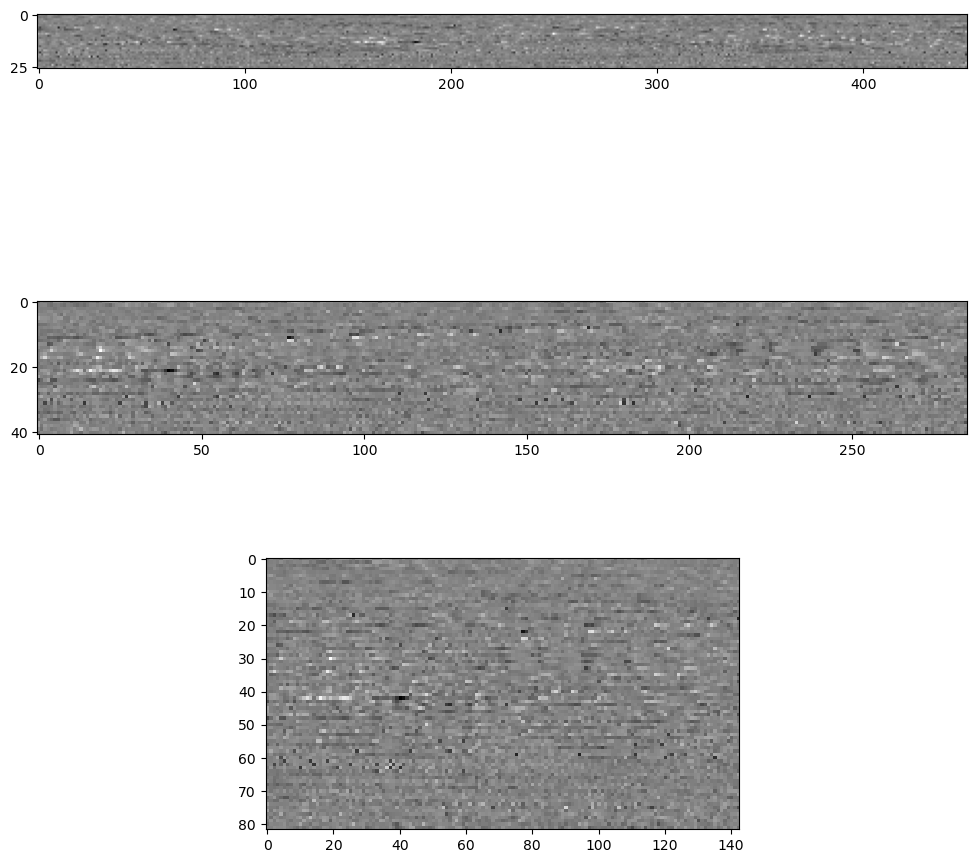

In [44]:
fig, ax = plt.subplots(nrows=3, ncols=1)
for r in range(3):
    train_sample = np.reshape(train_sample, factor_pairs[-3+r])
    ax[r].imshow(train_sample, cmap="gray")
fig.set_size_inches(12, 12)